In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.decomposition import NMF
from tqdm import tqdm

In [17]:
params = {'iterations':100, 
         'pre_iterations':100, 
         'seed': 43, 
         'lamb': 0.01,
         'layers': [128,64,32],
         }

In [34]:
def para(**kwargs):
    return kwargs

In [149]:
class DANMF(object):
    
    def __init__(self,
                 edge_df,
                 iterations = 1000, 
                 pre_iterations = 1000, 
                 seed = 43, 
                 lamb = 0.05,
                 layers =[32,8]):
        
        self.edge_df = edge_df
        self.iterations = iterations
        self.pre_iterations = pre_iterations
        self.seed = seed
        self.lamb =lamb
        self.layers = layers
        self.make_graph()
        self.A = nx.adjacency_matrix(self.graph)
        self.L = nx.laplacian_matrix(self.graph)
        self.D = self.L + self.A
        self.p = len(self.layers)
        
    def make_graph(self):
        
        self.graph = nx.from_edgelist([(cust,opp) for cust, opp in zip(self.edge_df['cust_id'],
                                                                 self.edge_df['opp_id'])])
    def setup_z(self, i):
        
        if i == 0:
            self.Z = self.A
        else:
            self.Z = self.V_s[i-1]
            
    def sklearn_pretrain(self, i):
        """
        Pretraining a single layer of the model with sklearn.
        :param i: Layer index.
        """
        nmf_model = NMF(n_components = self.layers[i],
                        init = "random",
                        random_state = self.seed,
                        max_iter = self.pre_iterations)

        U = nmf_model.fit_transform(self.Z)
        V = nmf_model.components_
        
        return U, V
    
    def pre_training(self):
        """
        Pre-training each NMF layer.
        """
        print("\nLayer pre-training started. \n")
        self.U_s = []
        self.V_s = []
        for i in tqdm(range(self.p), desc = "Layers trained: ", leave=True):
            self.setup_z(i)
            U, V = self.sklearn_pretrain(i)
            self.U_s.append(U)
            self.V_s.append(V)
            
    def setup_Q(self):
        """
        Setting up Q matrices.
        """
        self.Q_s = [None for _ in range(self.p + 1)]
        self.Q_s[self.p] = np.eye(self.layers[self.p - 1])
        for i in range(self.p - 1, -1, -1):
            self.Q_s[i] = np.dot(self.U_s[i], self.Q_s[i + 1])

    def update_U(self, i):
        """
        Updating left hand factors.
        :param i: Layer index.
        """
        if i == 0:
            R = self.U_s[0].dot(self.Q_s[1].dot(self.VpVpT).dot(self.Q_s[1].T))
            R = R+self.A_sq.dot(self.U_s[0].dot(self.Q_s[1].dot(self.Q_s[1].T)))
            Ru = 2*self.A.dot(self.V_s[self.p-1].T.dot(self.Q_s[1].T))
            self.U_s[0] = (self.U_s[0]*Ru)/np.maximum(R, 10**-10)
        else:
            R = self.P.T.dot(self.P).dot(self.U_s[i]).dot(self.Q_s[i+1]).dot(self.VpVpT).dot(self.Q_s[i+1].T)
            R = R+self.A_sq.dot(self.P).T.dot(self.P).dot(self.U_s[i]).dot(self.Q_s[i+1]).dot(self.Q_s[i+1].T)
            Ru = 2*self.A.dot(self.P).T.dot(self.V_s[self.p-1].T).dot(self.Q_s[i+1].T)
            self.U_s[i] = (self.U_s[i]*Ru)/np.maximum(R, 10**-10)
            
    def update_P(self, i):
        """
        Setting up P matrices.
        :param i: Layer index.
        """
        if i == 0:
            self.P = self.U_s[0]
        else:
            self.P = self.P.dot(self.U_s[i])

    def update_V(self, i):
        """
        Updating right hand factors.
        :param i: Layer index.
        """
        if i < self.p-1:
            Vu = 2*self.A.dot(self.P).T
            Vd = self.P.T.dot(self.P).dot(self.V_s[i])+self.V_s[i]
            self.V_s[i] = self.V_s[i] * Vu/np.maximum(Vd, 10**-10)
        else:
            Vu = 2*self.A.dot(self.P).T+(self.lamb * self.A.dot(self.V_s[i].T)).T
            Vd = self.P.T.dot(self.P).dot(self.V_s[i])
            Vd = Vd + self.V_s[i]+(self.lamb * self.D.dot(self.V_s[i].T)).T
            self.V_s[i] = self.V_s[i] * Vu/np.maximum(Vd, 10**-10)

    def calculate_cost(self, i):
        """
        Calculate loss.
        :param i: Global iteration.
        """
        reconstruction_loss_1 = np.linalg.norm(self.A - self.P.dot(self.V_s[-1]), ord="fro")**2
        reconstruction_loss_2 = np.linalg.norm(self.V_s[-1]-self.A.dot(self.P).T, ord="fro")**2
        regularization_loss = np.trace(self.V_s[-1].dot(self.L.dot(self.V_s[-1].T)))
        self.loss.append([i+1, reconstruction_loss_1, reconstruction_loss_2, regularization_loss])

    def save_embedding(self):
        """
        Save embedding matrix.
        """
        embedding = [np.array(range(self.P.shape[0])).reshape(-1, 1), self.P, self.V_s[-1].T]
        embedding = np.concatenate(embedding, axis=1)
        columns = ["id"] + ["x_" + str(x) for x in range(self.layers[-1]*2)]
        self.embedding = pd.DataFrame(embedding, columns=columns)
        
        return embedding
    
    def save_membership(self):
        """
        Save cluster membership.
        """
        index = np.argmax(self.P, axis=1)
        self.membership = {int(i): int(index[i]) for i in range(len(index))}
        
        return self.membership
    
    def training(self):
        """
        Training process after pre-training.
        """
        print("\n\nTraining started. \n")
        self.loss = []
        self.A_sq = self.A.dot(self.A.T)
        for iteration in tqdm(range(self.iterations), desc="Training pass: ", leave=True):
            self.setup_Q()
            self.VpVpT = self.V_s[self.p-1].dot(self.V_s[self.p-1].T)
            for i in range(self.p):
                self.update_U(i)
                self.update_P(i)
                self.update_V(i)
            self.calculate_cost(iteration)
            #print('current loss is:', self.loss[-1])
        self.membership = self.save_membership()
        self.embedding = self.save_embedding()
    
    

In [30]:
edge_df = pd.read_csv('/Users/shuaihengxiao/Desktop/DANMF/DANMF-master/input/chameleon_edges.csv',header=0,
                      names=['cust_id','opp_id'],)

In [31]:
edge_df

,cust_id,opp_id
0,0,933
1,0,598
2,1,81
3,1,4
4,1,254
...,...,...
8429,977,993
8430,977,980
8431,980,980
8432,980,993


In [32]:
import DANMF

In [38]:
model = DANMF.DANMF(edge_df = edge_df,
         iterations = 1000, 
         pre_iterations = 1000, 
         seed = 43, 
         lamb = 0.05,
         layers =[64,32,5],)

In [39]:
model.pre_training()
model.training()


Layer pre-training started. 



Layers trained: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]




Training started. 



Training pass: 100%|██████████| 1000/1000 [00:29<00:00, 34.01it/s]


In [40]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

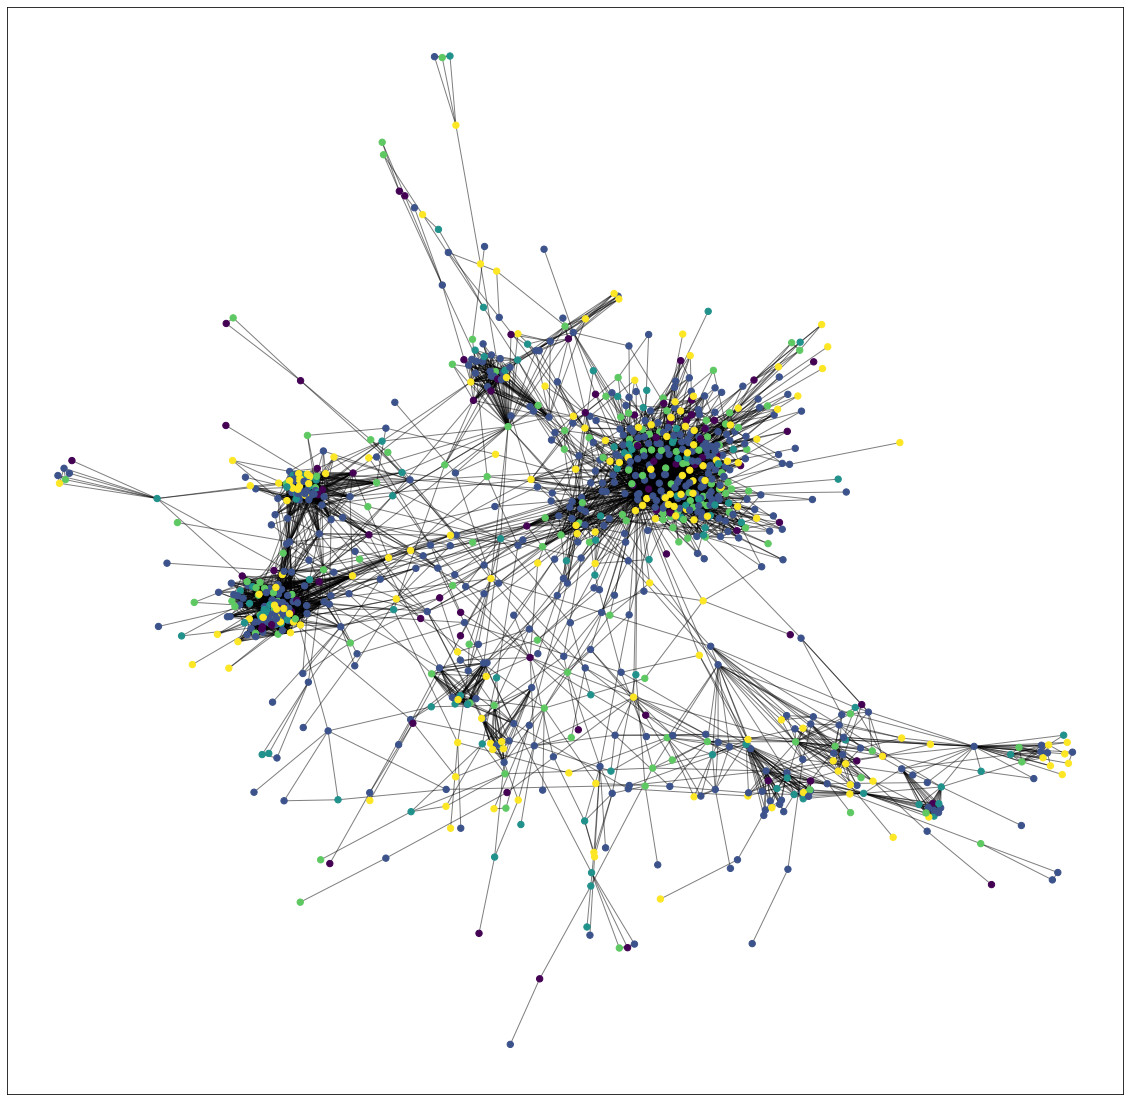

In [41]:
plt.figure(figsize = (20,20))
# draw the graph
pos = nx.spring_layout(model.graph)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(model.membership.values()) + 1)
nx.draw_networkx_nodes(model.graph, pos, model.membership.keys(), node_size=40, 
                       cmap=cmap, node_color=list(model.membership.values()))
nx.draw_networkx_edges(model.graph, pos, alpha=0.5)
plt.show()